# Problem Statement & Motivation

In today's digital age, the internet overwhelms people worldwide with an unprecedented volume of information sourced from various online platforms. Given the human tendency to trust initial impressions, it becomes essential to inspect the reliability of the sources we depend on for information. Regrettably, misinformation and misunderstandings pervade the digital landscape, posing a considerable challenge to the integrity of information dissemination. In light of this, our primary objective is to determine the origin of the images we encounter, discerning whether they have been generated by artificial intelligence or not.

# Dataset

Dataset: [Kaggle](https://www.kaggle.com/datasets/philosopher0808/real-vs-ai-generated-faces-dataset)

Our project utilizes a dataset sourced from Kaggle, comprising approximately 120,000 facial images. Of these, around 70,000 are authentic images captured through conventional photography, while the remaining 51,000 images are AI-generated. The dataset showcases a wide range of facial images, representing various demographics, including different ages, ethnic backgrounds, and genders. The diversity of our dataset is crucial for ensuring the robustness and generalizability of our deep-learning models. Training on such a varied collection of images guarantees that the model is exposed to a broad spectrum of features and patterns. This exposure significantly enhances the model's ability to generalize its learning to new, unseen images, thereby improving its performance and reliability.


# Data Loading & Package Import

In [ ]:
# delete the warning
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

In [ ]:
# import package
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split

In [ ]:
enable_wandb = True
use_gpu = True

In [ ]:
# test if the environment is GPU or not
gpu_available = torch.cuda.is_available()
gpu_available

True

In [ ]:
# log into wandb account
if enable_wandb:
  !pip install wandb -qU
  import wandb
  wandb.login()

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 13.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 13.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 267.1/267.1 kB 20.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 6.8 MB/s eta 0:00:00


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [ ]:
# mount to google drive in order to unzip the dataset
import pandas as pd
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip "/content/drive/MyDrive/Colab Notebooks/BA865_group_project/dataset.zip"

Streaming output truncated to the last 5000 lines.
  inflating: dataset/train/1/ebb4f0d76edbe1b4018327d779856c82b613141aa59542d09794cae63e724bd1.jpg  
  inflating: __MACOSX/dataset/train/1/._ebb4f0d76edbe1b4018327d779856c82b613141aa59542d09794cae63e724bd1.jpg  
  inflating: dataset/train/1/SFHQ_pt1_00003927.jpg  
  inflating: __MACOSX/dataset/train/1/._SFHQ_pt1_00003927.jpg  
  inflating: dataset/train/1/SFHQ_pt2_00003244.jpg  
  inflating: __MACOSX/dataset/train/1/._SFHQ_pt2_00003244.jpg  
  inflating: dataset/train/1/SFHQ_pt3_00001050.jpg  
  inflating: __MACOSX/dataset/train/1/._SFHQ_pt3_00001050.jpg  
  inflating: dataset/train/1/SFHQ_pt2_00081535.jpg  
  inflating: __MACOSX/dataset/train/1/._SFHQ_pt2_00081535.jpg  
  inflating: dataset/train/1/0da062db44a837714d994217ee35dae47e67e7d2.jpg  
  inflating: __MACOSX/dataset/train/1/._0da062db44a837714d994217ee35dae47e67e7d2.jpg  
  inflating: dataset/train/1/c5580f924a937a338f0b23fab3a572f2883c9ddfc35bc71bc0668688f68c2c27.jpg  
  infla

# Data Augmentation

In [ ]:
configs = {
    "data_augmentation":True,
    "pretrained": True,
                    # false: the parameter I use in pretrained will be random, not completely follow the pretrained model
                    # cause: the training process will be slow
                    # => it's better to use pretrained model
    "efficientnet":True,
                    # true: aim to achieve higher performance using fewer computational resources.
                    # These models adjust their size and complexity to strike a balance between accuracy and efficiency,
    "transferlearning": False
}

In [ ]:
if configs['data_augmentation']:
      transform = transforms.Compose([
      transforms.RandomHorizontalFlip(0.5),
      transforms.Resize(112),       # Resize the image to 112x112 pixels while maintaining aspect ratio
      transforms.RandomCrop(112),
      transforms.RandomRotation(45),
      transforms.ColorJitter(), # add a coast of color layer to the original image
      transforms.ToTensor(),   # Convert the image to a PyTorch tensor
      transforms.Normalize(mean=[0.485, 0.456, 0.406],  # Normalize the tensor
                           std=[0.229, 0.224, 0.225])
  ])
else:
  transform = transforms.Compose([
      transforms.Resize(512),       # Resize the image to 512x512 pixels while maintaining aspect ratio
      transforms.CenterCrop(512),  # most of the image will center in the middle of the image, so you will extract most info from here
      transforms.ToTensor(),       # Convert the image to a PyTorch tensor
      transforms.Normalize(mean=[0.485, 0.456, 0.406],  # Normalize the tensor
                           std=[0.229, 0.224, 0.225])
  ])


import torchvision
# with data augmentation
train_dataset = torchvision.datasets.ImageFolder("/content/dataset/train", transform=transform)
val_dataset = torchvision.datasets.ImageFolder("/content/dataset/validate", transform=transform)
test_dataset = torchvision.datasets.ImageFolder("/content/dataset/test", transform=transform)

transform2 = transforms.Compose([
    transforms.Resize(224),  # Resize the image to 224x224 pixels while maintaining aspect ratio
    transforms.CenterCrop(224),  # Center crop to 224x224 pixels
    transforms.ToTensor(),  # Convert the image to a PyTorch tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])  # Normalize the tensor
])
train_dataset.transform = transform2
val_dataset.transform = transform2
test_dataset.transform = transform2

# Define Classes

## Accuracy

In [ ]:
def get_accuracy(dataloader, model):

    # initialize the incremented count
    acc = 0
    correct_predictions = 0
    total_predictions = 0

    with torch.no_grad(): # disables gradient calculation (update the weight & bias)
                          # time: when you are doing evaluation of your model
        model.eval()  # Set model to evaluation mode

        for images, labels in dataloader:
            if gpu_available and use_gpu:
                images = images.cuda()
                labels = labels.cuda()

            outputs = model(images)  # Get predictions

            # Get predicted class
            if configs["transferlearning"]:
              _, predicted = torch.max(outputs.logits, 1)
            else:
              _, predicted = torch.max(outputs, 1)

            correct_predictions += (predicted == labels).sum().item()
            total_predictions += labels.size(0)
                                 # labels: tensor([1, 0, 1])
                                 # labels.size(0): 3
                                 # size(0): return the labels size to me
                                 # coz it's a 1D tensor so only put 0 in size(0)
    acc = correct_predictions / total_predictions
    return acc

## Loss

In [ ]:
criterion = nn.CrossEntropyLoss()

In [ ]:
def get_loss(loader): ### in pytorch loss function already include softmax, so you don't need to specific add softmax in the last layer

  with torch.no_grad():

    loss = 0
    for i, (images, labels) in enumerate(loader): # The batches.
          # step1: Move data to cuda. Make sure the model is on cuda too!
          if gpu_available and use_gpu:
            images = images.cuda()
            labels = labels.cuda()

          # step2: Forward pass
          outputs = model(images)
          if configs["transferlearning"]:
            outputs = outputs.logits

          # step 3: calculate the loss.
          loss = loss + criterion(outputs, labels)
    return loss/ len(loader)

## Early Stopping

In [ ]:
class EarlyStopper:
    def __init__(self, patience=1):
        self.patience = patience
        self.counter = 0
        self.min_validation_loss = float('inf')

    def early_stop(self, validation_loss):

        # If the new loss is lower than the old loss, reset the counter
        if validation_loss < self.min_validation_loss:
            self.min_validation_loss = validation_loss
            self.counter = 0

            # Keep track of the best model by saving it on the hard drive.
            torch.save(model.state_dict(), "./best_model.pt")

        # otherwise, increment the counter.
        elif validation_loss > self.min_validation_loss:
            self.counter += 1

            if self.counter >= self.patience: # terminate
                return True
        return False

# Model Training

## CNN

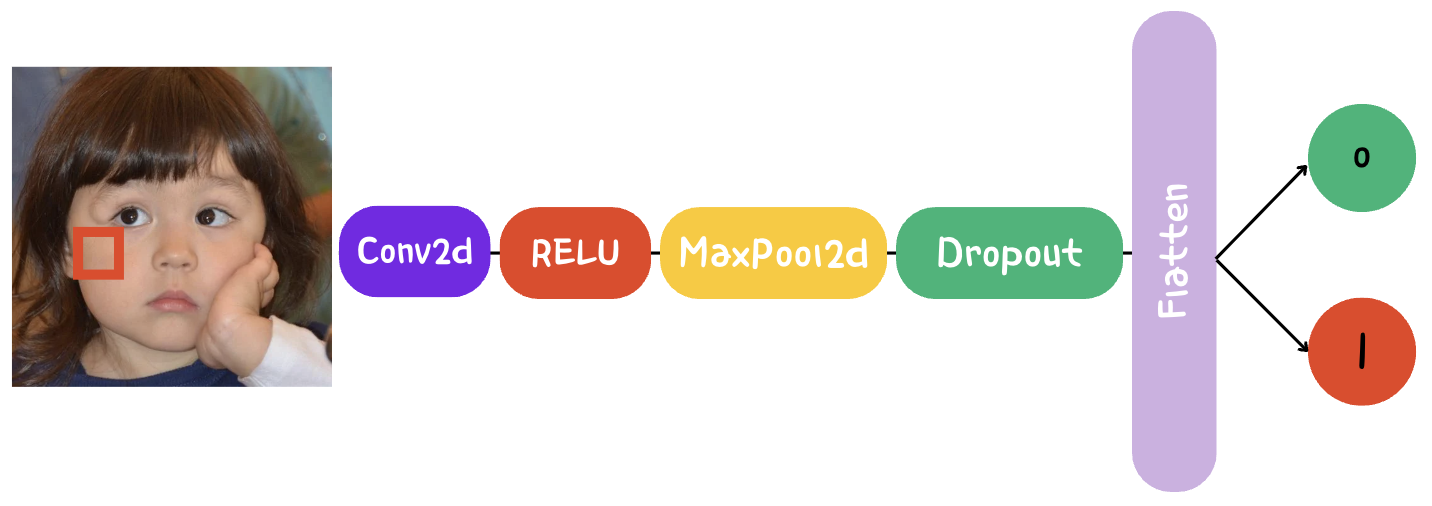

In [ ]:
!pip install transformers

### CNN Construction

We use a CNN as our first model. It features three convolutional layers with ReLU activation, followed by max-pooling and dropout to prevent overfitting. The layers have increasing filter counts—32, 64, and 128—with each having a 5x5 kernel, a stride of 2, and padding of 1. After the convolutional layers, the network flattens the feature maps into a 1D vector for the fully connected layers. The model has two intermediate fully connected layers with 500 and 225 features, each with a ReLU activation function. The output layer has two logits, representing raw scores for binary classification. We use cross-entropy as our loss function, which is appropriate for binary classification. Cross-entropy loss applies a sigmoid transformation to the logits, which are the raw outputs from the final linear layer, before calculating the loss. This transformation creates a probabilistic representation of the output, allowing the model to learn to maximize the probability of the correct class. We use SGD as the optimizer, updating model parameters based on mini-batches from the training dataset.

In [ ]:
# Hyperparameter for CNN
sweep_config = {
    "method": "grid",
    "metric": {"name": "loss" , "goal": "minimize"}, # when you have a specific target to find
    "parameters": {
        'batch_size': {'values': [32, 64, 128]},
        'learning_rate': {'values': [1e-2, 1e-3, 1e-4]}}
}

configs = {
    "experiment_name": "project-luckluck",
    "freeze_feature_extraction_layers": False,
                                  # true: the hidden layer won't change, which mean the weight wil not get update too
                                  # it means that the weights of the layers responsible for feature extraction (typically the earlier layers) are frozen or kept constant during training. This prevents their weights from being updated during the training process
                                  # train speed will be slow
                                  # => it's better to change to "False"
    "pretrained": True,
                    # false: the parameter I use in pretrained will be random, not completely follow the pretrained model
                    # cause: the training process will be slow
                    # => it's better to use pretrained model
    "efficientnet":True,
                    # true: aim to achieve higher performance using fewer computational resources.
                    # These models adjust their size and complexity to strike a balance between accuracy and efficiency,
    "data_augmentation":True,
    "transferlearning": False,

    # Data
    "img_dimensions" : (3,512,512),
    "num_classes" : 2, # binary classification

    # CNN
    "filter_sizes" : [32,64,128],
                    # each kernal will have # filter (how many features do you want to capture)
    "kernel_size" : 5,
    "stride": 2,
    "padding": 1,
    "momentum": 0.9,
    "epochs" : 1,
    "weight_decay" : 0.00001
}

In [ ]:
# CNN model
class CNN(nn.Module):
    def __init__(self, output_size):
        super(CNN, self).__init__()
        self.model = nn.Sequential(
            torch.nn.Conv2d(configs["img_dimensions"][0], configs["filter_sizes"][0], configs["kernel_size"], stride=configs["stride"], padding=configs["padding"]),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(2),
            torch.nn.Dropout(0.25),

            torch.nn.Conv2d(configs["filter_sizes"][0], configs["filter_sizes"][1], configs["kernel_size"], stride=configs["stride"], padding=configs["padding"]),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(2),
            torch.nn.Dropout(0.25),

            torch.nn.Conv2d(configs["filter_sizes"][1], configs["filter_sizes"][2], configs["kernel_size"], stride=configs["stride"], padding=configs["padding"]),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(2),
            torch.nn.Dropout(0.25),
            nn.Flatten(),
            nn.Linear(1152, 500),
            nn.ReLU(),
            nn.Linear(500, 225),
            nn.ReLU(),
            nn.Linear(225, output_size),
                          # in our dataset, we'll set to 2
        )

    # Defines the forward pass.
    def forward(self, x):
        x = x.view(-1, 3, 224, 224)
            # .view: reshape our input data type
            # -1: it'll self capture how many images we have
        return self.model(x)

In [ ]:
# call out CNN model

import torchvision.models as models
from transformers import AutoModelForImageClassification

if configs["transferlearning"]:
  # model 1: teacher's pretrained model
  if not configs["efficientnet"]:
    model = models.resnet18(pretrained=configs["pretrained"])
  # model 2: our pretrained model - from hugging face
  else:
    model = AutoModelForImageClassification.from_pretrained("dima806/ai_vs_real_image_detection")
# model 3: CNN
else:
  model = CNN(configs["num_classes"])

if gpu_available and use_gpu:
  model = model.cuda()

In [ ]:
print(model)

CNN(
  (model): Sequential(
    (0): Conv2d(3, 32, kernel_size=(5, 5), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Dropout(p=0.25, inplace=False)
    (4): Conv2d(32, 64, kernel_size=(5, 5), stride=(2, 2), padding=(1, 1))
    (5): ReLU()
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Dropout(p=0.25, inplace=False)
    (8): Conv2d(64, 128, kernel_size=(5, 5), stride=(2, 2), padding=(1, 1))
    (9): ReLU()
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Dropout(p=0.25, inplace=False)
    (12): Flatten(start_dim=1, end_dim=-1)
    (13): Linear(in_features=1152, out_features=500, bias=True)
    (14): ReLU()
    (15): Linear(in_features=500, out_features=225, bias=True)
    (16): ReLU()
    (17): Linear(in_features=225, out_features=2, bias=True)
  )
)


In [ ]:
!pip install torchinfo

In [ ]:
from torchinfo import summary

summary(model, (1,3, 224,224))

Layer (type:depth-idx)                   Output Shape              Param #
CNN                                      [1, 2]                    --
├─Sequential: 1-1                        [1, 2]                    --
│    └─Conv2d: 2-1                       [1, 32, 111, 111]         2,432
│    └─ReLU: 2-2                         [1, 32, 111, 111]         --
│    └─MaxPool2d: 2-3                    [1, 32, 55, 55]           --
│    └─Dropout: 2-4                      [1, 32, 55, 55]           --
│    └─Conv2d: 2-5                       [1, 64, 27, 27]           51,264
│    └─ReLU: 2-6                         [1, 64, 27, 27]           --
│    └─MaxPool2d: 2-7                    [1, 64, 13, 13]           --
│    └─Dropout: 2-8                      [1, 64, 13, 13]           --
│    └─Conv2d: 2-9                       [1, 128, 6, 6]            204,928
│    └─ReLU: 2-10                        [1, 128, 6, 6]            --
│    └─MaxPool2d: 2-11                   [1, 128, 3, 3]            --
│  

### CNN Training

In [ ]:
if gpu_available and use_gpu:
  model = model.cuda()

In [ ]:
def main():
  run = wandb.init(config=configs)

# Data loaders: clip the whole dataset to batches
  train_loader = DataLoader(dataset=train_dataset, batch_size=wandb.config.batch_size, shuffle=True)
                                                                                # only can use on training data
  val_loader = DataLoader(dataset=val_dataset, batch_size=wandb.config.batch_size, shuffle=False)
  test_loader = DataLoader(dataset=test_dataset, batch_size=wandb.config.batch_size, shuffle=False)

  criterion = nn.CrossEntropyLoss()
  optimizer = optim.SGD(model.parameters(), momentum=configs['momentum'], lr=wandb.config.learning_rate, weight_decay=configs['weight_decay'])

  early_stopper = EarlyStopper(patience=7)
  scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.3, patience=3)

  # Training loop
  for epoch in range(configs["epochs"]): # The epochs.
      for i, (images, labels) in enumerate(train_loader): # The batches.
          # step 1: Zero out the gradients.
          optimizer.zero_grad()

          # step 1.1 move data to cuda. Make sure the model is on cuda too!
          if gpu_available and use_gpu:
            images = images.cuda()
            labels = labels.cuda()

          # step2: Forward pass
          outputs = model(images)

          # step 3: calculate the loss.
          loss = criterion(outputs, labels)

          # Calculate accuracy
          _, predicted = torch.max(outputs, 1)
          total = 0
          correct = 0
          total += labels.size(0)
          correct += (predicted == labels).sum().item()

          acc = correct / total

          # step 4: Backward pass
          loss.backward()
          optimizer.step()

          # Print the loss and accuracy
          if i %100 == 0:
            print("Epoch", epoch+ 1, " batch", i+1, ". Training Loss: ", loss.item(),". Traning Accuracy:", acc)
            if enable_wandb:
              wandb.log({"loss": loss, "accuracy": acc})

      # Compute total train accuracy
      train_acc = get_accuracy(train_loader, model)
      val_acc = get_accuracy(val_loader, model)

      train_loss = get_loss(train_loader)
      validation_loss = get_loss(val_loader)


      wandb.log({"train_acc":train_acc, "val_loss": validation_loss})

      print(f'Epoch [{epoch + 1}/{configs["epochs"]}], LR: {optimizer.param_groups[0]["lr"]},Train Accuracy: {train_acc:.4f},Train Loss: {train_loss.item():.4f} ,  Validation Accuracy: {val_acc:.4f}, Validation Loss: {validation_loss.item():.4f}')
      if enable_wandb:
        wandb.log({"epoch": epoch + 1, "LR": {optimizer.param_groups[0]['lr']}, "train_accuracy": train_acc, "train_loss":train_loss.item(), "val_accuracy": val_acc, "val_loss": validation_loss.item()})

      scheduler.step(validation_loss)

      if early_stopper.early_stop(validation_loss):
          print("Validation loss hasn't dropped. Early stopping!")
          break


  # Once training is done, load the best model (might not be the last model due to early stopping)
  model.load_state_dict(torch.load("./best_model.pt"))
  acc = get_accuracy(test_loader, model)
  loss = get_loss(test_loader)
  print("best model accuracy performance on Test set:", acc)
  print("best model loss performance on Test set:", loss)

  if enable_wandb:
    wandb.summary['Test Accuracy'] = acc
    wandb.summary['Test Loss'] = loss
sweep_id = wandb.sweep(sweep_config, project="865-project-final")
wandb.agent(sweep_id, function=main)

Create sweep with ID: q3x6p2yd
Sweep URL: https://wandb.ai/ba865_group2/865-project-final/sweeps/q3x6p2yd


wandb: Agent Starting Run: ii8f67u9 with config:
wandb: 	batch_size: 32
wandb: 	learning_rate: 0.01
wandb: Currently logged in as: bonny622 (ba865_group2). Use `wandb login --relogin` to force relogin


Epoch 1  batch 1 . Training Loss:  0.6936355829238892 . Traning Accuracy: 0.5625
Epoch 1  batch 101 . Training Loss:  0.6655899286270142 . Traning Accuracy: 0.59375
Epoch 1  batch 201 . Training Loss:  0.668473482131958 . Traning Accuracy: 0.59375
Epoch 1  batch 301 . Training Loss:  0.6623241305351257 . Traning Accuracy: 0.625
Epoch 1  batch 401 . Training Loss:  0.72772216796875 . Traning Accuracy: 0.5625
Epoch 1  batch 501 . Training Loss:  0.6017174124717712 . Traning Accuracy: 0.65625
Epoch 1  batch 601 . Training Loss:  0.6470567584037781 . Traning Accuracy: 0.65625
Epoch 1  batch 701 . Training Loss:  0.6923158168792725 . Traning Accuracy: 0.625
Epoch 1  batch 801 . Training Loss:  0.5691741704940796 . Traning Accuracy: 0.65625
Epoch 1  batch 901 . Training Loss:  0.5234706997871399 . Traning Accuracy: 0.84375
Epoch 1  batch 1001 . Training Loss:  0.6402091383934021 . Traning Accuracy: 0.6875
Epoch 1  batch 1101 . Training Loss:  0.5297030806541443 . Traning Accuracy: 0.78125
Ep

accuracy,▁▂▂▂▁▃▃▂▃▇▄▆▅▅▅▆▅█▃▅▇▅█
epoch,▁
loss,▇▇▇▇█▆▇▇▅▄▆▄▄▅▅▄▅▂▄▃▃▄▁
train_acc,▁
train_accuracy,▁
train_loss,▁
val_accuracy,▁
val_loss,▁▁
Test Accuracy,0.81542
Test Loss,0.41748
accuracy,0.875


wandb: Agent Starting Run: 5g08tn71 with config:
wandb: 	batch_size: 32
wandb: 	learning_rate: 0.001


Epoch 1  batch 1 . Training Loss:  0.48590677976608276 . Traning Accuracy: 0.84375
Epoch 1  batch 101 . Training Loss:  0.4079429805278778 . Traning Accuracy: 0.8125
Epoch 1  batch 201 . Training Loss:  0.5583418011665344 . Traning Accuracy: 0.75
Epoch 1  batch 301 . Training Loss:  0.4697911739349365 . Traning Accuracy: 0.78125
Epoch 1  batch 401 . Training Loss:  0.6447725892066956 . Traning Accuracy: 0.71875
Epoch 1  batch 501 . Training Loss:  0.42379212379455566 . Traning Accuracy: 0.84375
Epoch 1  batch 601 . Training Loss:  0.5170016884803772 . Traning Accuracy: 0.71875
Epoch 1  batch 701 . Training Loss:  0.37630516290664673 . Traning Accuracy: 0.78125
Epoch 1  batch 801 . Training Loss:  0.298825204372406 . Traning Accuracy: 0.875
Epoch 1  batch 901 . Training Loss:  0.3819517195224762 . Traning Accuracy: 0.84375
Epoch 1  batch 1001 . Training Loss:  0.30976101756095886 . Traning Accuracy: 0.875
Epoch 1  batch 1101 . Training Loss:  0.36633116006851196 . Traning Accuracy: 0.81

accuracy,▅▄▂▃▁▅▁▃▅▅▅▄▅▇▄▅▅▅▅▅▆█▅
epoch,▁
loss,▆▅▇▆█▅▆▄▃▄▃▄▄▂▆▅▃▃▄▃▂▁▃
train_acc,▁
train_accuracy,▁
train_loss,▁
val_accuracy,▁
val_loss,▁▁
Test Accuracy,0.87962
Test Loss,0.297
accuracy,0.84375


wandb: Agent Starting Run: eb123j58 with config:
wandb: 	batch_size: 32
wandb: 	learning_rate: 0.0001


Epoch 1  batch 1 . Training Loss:  0.18501868844032288 . Traning Accuracy: 0.9375
Epoch 1  batch 101 . Training Loss:  0.22763283550739288 . Traning Accuracy: 0.96875
Epoch 1  batch 201 . Training Loss:  0.33780238032341003 . Traning Accuracy: 0.84375
Epoch 1  batch 301 . Training Loss:  0.231358602643013 . Traning Accuracy: 0.875
Epoch 1  batch 401 . Training Loss:  0.18149608373641968 . Traning Accuracy: 0.90625
Epoch 1  batch 501 . Training Loss:  0.16130143404006958 . Traning Accuracy: 0.9375
Epoch 1  batch 601 . Training Loss:  0.313218891620636 . Traning Accuracy: 0.90625
Epoch 1  batch 701 . Training Loss:  0.1996244192123413 . Traning Accuracy: 0.90625
Epoch 1  batch 801 . Training Loss:  0.26693835854530334 . Traning Accuracy: 0.875
Epoch 1  batch 901 . Training Loss:  0.21765395998954773 . Traning Accuracy: 0.90625
Epoch 1  batch 1001 . Training Loss:  0.26279962062835693 . Traning Accuracy: 0.875
Epoch 1  batch 1101 . Training Loss:  0.2034776359796524 . Traning Accuracy: 0.

accuracy,▆▇▄▅▅▆▅▅▅▅▅▅▅█▅▅▅▁▅▇▆▅▇
epoch,▁
loss,▂▃▆▃▂▂▅▃▄▃▄▃▂▁▂▃▃█▃▁▃▆▁
train_acc,▁
train_accuracy,▁
train_loss,▁
val_accuracy,▁
val_loss,▁▁
Test Accuracy,0.88971
Test Loss,0.27373
accuracy,0.96875


wandb: Agent Starting Run: jm2culbo with config:
wandb: 	batch_size: 64
wandb: 	learning_rate: 0.01


Epoch 1  batch 1 . Training Loss:  0.28796467185020447 . Traning Accuracy: 0.875
Epoch 1  batch 101 . Training Loss:  0.3138788342475891 . Traning Accuracy: 0.84375
Epoch 1  batch 201 . Training Loss:  0.37328609824180603 . Traning Accuracy: 0.84375
Epoch 1  batch 301 . Training Loss:  0.4538116753101349 . Traning Accuracy: 0.8125
Epoch 1  batch 401 . Training Loss:  0.16124780476093292 . Traning Accuracy: 0.96875
Epoch 1  batch 501 . Training Loss:  0.3546377420425415 . Traning Accuracy: 0.84375
Epoch 1  batch 601 . Training Loss:  0.28475627303123474 . Traning Accuracy: 0.859375
Epoch 1  batch 701 . Training Loss:  0.31956517696380615 . Traning Accuracy: 0.84375
Epoch 1  batch 801 . Training Loss:  0.13311417400836945 . Traning Accuracy: 0.96875
Epoch 1  batch 901 . Training Loss:  0.3256072700023651 . Traning Accuracy: 0.859375
Epoch 1  batch 1001 . Training Loss:  0.16597533226013184 . Traning Accuracy: 0.953125
Epoch 1  batch 1101 . Training Loss:  0.21081282198429108 . Traning Ac

accuracy,▄▂▂▁█▂▃▂█▃▇▇
epoch,▁
loss,▄▅▆█▂▆▄▅▁▅▂▃
train_acc,▁
train_accuracy,▁
train_loss,▁
val_accuracy,▁
val_loss,▁▁
Test Accuracy,0.89595
Test Loss,0.26634
accuracy,0.9375


wandb: Agent Starting Run: sj1z8syx with config:
wandb: 	batch_size: 64
wandb: 	learning_rate: 0.001


Epoch 1  batch 1 . Training Loss:  0.19688892364501953 . Traning Accuracy: 0.953125
Epoch 1  batch 101 . Training Loss:  0.20799726247787476 . Traning Accuracy: 0.890625
Epoch 1  batch 201 . Training Loss:  0.08104552328586578 . Traning Accuracy: 0.984375
Epoch 1  batch 301 . Training Loss:  0.1435762643814087 . Traning Accuracy: 0.953125
Epoch 1  batch 401 . Training Loss:  0.16531085968017578 . Traning Accuracy: 0.921875
Epoch 1  batch 501 . Training Loss:  0.1229572519659996 . Traning Accuracy: 0.953125
Epoch 1  batch 601 . Training Loss:  0.06441622227430344 . Traning Accuracy: 0.984375
Epoch 1  batch 701 . Training Loss:  0.1486252248287201 . Traning Accuracy: 0.96875
Epoch 1  batch 801 . Training Loss:  0.18770022690296173 . Traning Accuracy: 0.90625
Epoch 1  batch 901 . Training Loss:  0.168077751994133 . Traning Accuracy: 0.9375
Epoch 1  batch 1001 . Training Loss:  0.1406378149986267 . Traning Accuracy: 0.96875
Epoch 1  batch 1101 . Training Loss:  0.07213876396417618 . Tranin

accuracy,▅▁▇▅▃▅▇▆▂▄▆█
epoch,▁
loss,▇█▂▅▆▄▁▅▇▆▅▁
train_acc,▁
train_accuracy,▁
train_loss,▁
val_accuracy,▁
val_loss,▁▁
Test Accuracy,0.92844
Test Loss,0.19333
accuracy,1.0


wandb: Agent Starting Run: 9q11h4nz with config:
wandb: 	batch_size: 64
wandb: 	learning_rate: 0.0001


Epoch 1  batch 1 . Training Loss:  0.08062722533941269 . Traning Accuracy: 0.96875
Epoch 1  batch 101 . Training Loss:  0.13248302042484283 . Traning Accuracy: 0.921875
Epoch 1  batch 201 . Training Loss:  0.15293999016284943 . Traning Accuracy: 0.953125
Epoch 1  batch 301 . Training Loss:  0.06084192916750908 . Traning Accuracy: 0.984375
Epoch 1  batch 401 . Training Loss:  0.17682655155658722 . Traning Accuracy: 0.921875
Epoch 1  batch 501 . Training Loss:  0.10603087395429611 . Traning Accuracy: 0.953125
Epoch 1  batch 601 . Training Loss:  0.10889115929603577 . Traning Accuracy: 0.96875
Epoch 1  batch 701 . Training Loss:  0.04717161878943443 . Traning Accuracy: 0.984375
Epoch 1  batch 801 . Training Loss:  0.050636425614356995 . Traning Accuracy: 0.984375
Epoch 1  batch 901 . Training Loss:  0.21214136481285095 . Traning Accuracy: 0.90625
Epoch 1  batch 1001 . Training Loss:  0.1509719043970108 . Traning Accuracy: 0.921875
Epoch 1  batch 1101 . Training Loss:  0.06677816063165665 

accuracy,▇▂▅█▂▅▇██▁▂█
epoch,▁
loss,▂▅▅▂▇▃▄▁▁█▅▂
train_acc,▁
train_accuracy,▁
train_loss,▁
val_accuracy,▁
val_loss,▁▁
Test Accuracy,0.93208
Test Loss,0.19044
accuracy,0.98438


wandb: Agent Starting Run: 607yr36g with config:
wandb: 	batch_size: 128
wandb: 	learning_rate: 0.01


Epoch 1  batch 1 . Training Loss:  0.1345495730638504 . Traning Accuracy: 0.9453125
Epoch 1  batch 101 . Training Loss:  0.09933693706989288 . Traning Accuracy: 0.96875
Epoch 1  batch 201 . Training Loss:  0.10963662713766098 . Traning Accuracy: 0.96875
Epoch 1  batch 301 . Training Loss:  0.09224043041467667 . Traning Accuracy: 0.96875
Epoch 1  batch 401 . Training Loss:  0.17566566169261932 . Traning Accuracy: 0.921875
Epoch 1  batch 501 . Training Loss:  0.14513403177261353 . Traning Accuracy: 0.9609375
Epoch [1/1], LR: 0.01,Train Accuracy: 0.9611,Train Loss: 0.1189 ,  Validation Accuracy: 0.9312, Validation Loss: 0.1857
best model accuracy performance on Test set: 0.9279454319966929
best model loss performance on Test set: tensor(0.1921, device='cuda:0')


accuracy,▅███▁▇
epoch,▁
loss,▅▂▂▁█▅
train_acc,▁
train_accuracy,▁
train_loss,▁
val_accuracy,▁
val_loss,▁▁
Test Accuracy,0.92795
Test Loss,0.19212
accuracy,0.96094


wandb: Agent Starting Run: kezb0fba with config:
wandb: 	batch_size: 128
wandb: 	learning_rate: 0.001


Epoch 1  batch 1 . Training Loss:  0.10023941099643707 . Traning Accuracy: 0.9765625
Epoch 1  batch 101 . Training Loss:  0.12071603536605835 . Traning Accuracy: 0.953125
Epoch 1  batch 201 . Training Loss:  0.11486441642045975 . Traning Accuracy: 0.9609375
Epoch 1  batch 301 . Training Loss:  0.08472959697246552 . Traning Accuracy: 0.9609375
Epoch 1  batch 401 . Training Loss:  0.105731301009655 . Traning Accuracy: 0.9609375
Epoch 1  batch 501 . Training Loss:  0.09461648762226105 . Traning Accuracy: 0.9765625
Epoch [1/1], LR: 0.001,Train Accuracy: 0.9782,Train Loss: 0.0689 ,  Validation Accuracy: 0.9388, Validation Loss: 0.1769
best model accuracy performance on Test set: 0.9362959900785448
best model loss performance on Test set: tensor(0.1867, device='cuda:0')


accuracy,█▁▃▃▃█
epoch,▁
loss,▄█▇▁▅▃
train_acc,▁
train_accuracy,▁
train_loss,▁
val_accuracy,▁
val_loss,▁▁
Test Accuracy,0.9363
Test Loss,0.18666
accuracy,0.97656


wandb: Agent Starting Run: r82rl4d7 with config:
wandb: 	batch_size: 128
wandb: 	learning_rate: 0.0001


Epoch 1  batch 1 . Training Loss:  0.02055952697992325 . Traning Accuracy: 0.9921875
Epoch 1  batch 101 . Training Loss:  0.07321832329034805 . Traning Accuracy: 0.96875
Epoch 1  batch 201 . Training Loss:  0.14590561389923096 . Traning Accuracy: 0.9609375
Epoch 1  batch 301 . Training Loss:  0.05339745432138443 . Traning Accuracy: 0.9765625
Epoch 1  batch 401 . Training Loss:  0.08690987527370453 . Traning Accuracy: 0.9765625
Epoch 1  batch 501 . Training Loss:  0.10236380994319916 . Traning Accuracy: 0.96875
Epoch [1/1], LR: 0.0001,Train Accuracy: 0.9791,Train Loss: 0.0666 ,  Validation Accuracy: 0.9396, Validation Loss: 0.1767
best model accuracy performance on Test set: 0.9374534931789996
best model loss performance on Test set: tensor(0.1864, device='cuda:0')


accuracy,█▃▁▅▅▃
epoch,▁
loss,▁▄█▃▅▆
train_acc,▁
train_accuracy,▁
train_loss,▁
val_accuracy,▁
val_loss,▁▁
Test Accuracy,0.93745
Test Loss,0.18639
accuracy,0.96875


wandb: Sweep Agent: Waiting for job.
wandb: Sweep Agent: Exiting.


### Wandb

https://api.wandb.ai/links/bostonuniversity-olivia/1d0szlol